In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [122]:
x_data = pd.read_csv("data/x.csv", sep=";")

In [123]:
y_data_ = pd.read_csv("data/y.csv", sep=";")

In [124]:
x_data.head() 

,Swedbank_A-price-0,Swedbank_A-volume-0,Swedbank_A-price-1,Swedbank_A-volume-1,Swedbank_A-price-2,Swedbank_A-volume-2,Swedbank_A-price-3,Swedbank_A-volume-3,Swedbank_A-price-4,Swedbank_A-volume-4,...,Swedbank_A-price-15,Swedbank_A-volume-15,Swedbank_A-price-16,Swedbank_A-volume-16,Swedbank_A-price-17,Swedbank_A-volume-17,Swedbank_A-price-18,Swedbank_A-volume-18,Swedbank_A-price-19,Swedbank_A-volume-19
0,143.60,2000.0,143.60,1266.0,143.60,1.0,143.60,1182.0,143.60,1515.0,...,143.60,710.0,143.60,671.0,143.60,675.0,143.60,710.0,143.60,7195.0
1,143.60,2000.0,143.60,1266.0,143.60,1.0,143.60,1182.0,143.60,1515.0,...,143.60,710.0,143.60,671.0,143.60,675.0,143.60,710.0,143.60,7195.0
2,143.60,2000.0,143.60,1266.0,143.60,1.0,143.60,1182.0,143.60,1515.0,...,143.60,710.0,143.60,671.0,143.60,675.0,143.60,710.0,143.60,7195.0
3,143.60,2000.0,143.60,1266.0,143.60,1.0,143.60,1182.0,143.60,1515.0,...,143.60,710.0,143.60,671.0,143.60,675.0,143.60,710.0,143.60,7195.0
4,145.14,340.0,145.14,343.0,145.14,317.0,145.14,25.0,145.14,1.0,...,145.14,35.0,145.14,308.0,145.14,169.0,145.14,174.0,145.14,144.0


In [125]:
y_data_.head()

,15s,15sa,15ud,30s,30sa,30ud,45s,45sa,45ud,60s,...,180s,180sa,180ud,300s,300sa,300ud,600s,600sa,600ud,ts
0,145.14,145.14,1,145.14,145.14,1,145.24,145.24,1,145.32,...,145.16,145.16,1,145.34,145.34,1,145.26,145.26,1,1.604390e+09
1,145.14,145.14,1,145.14,145.14,1,145.24,145.24,1,145.32,...,145.16,145.16,1,145.34,145.34,1,145.26,145.26,1,1.604390e+09
2,145.14,145.14,1,145.14,145.14,1,145.24,145.24,1,145.32,...,145.16,145.16,1,145.34,145.34,1,145.26,145.26,1,1.604390e+09
3,145.14,145.14,1,145.14,145.14,1,145.24,145.24,1,145.32,...,145.16,145.16,1,145.34,145.34,1,145.26,145.26,1,1.604390e+09
4,145.14,145.14,1,145.14,145.14,1,145.24,145.24,1,145.32,...,145.16,145.16,1,145.34,145.34,1,145.26,145.26,1,1.604390e+09


In [126]:
x_data.shape

(1962338, 40)

In [127]:
y_data = y_data_[:-2]
y_data = y_data["300s"] #300s - 5min exakt price
y_data.shape

(1962338,)

In [128]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].to_numpy(), dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].to_numpy(), dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].to_numpy(), dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].to_numpy(), dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].to_numpy(), dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].to_numpy(), dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), zip(test_data_x, test_data_y)

In [129]:
train_data, dev_data, test_data = splitData(x_data, y_data, 0.8)

In [38]:
input_size=40
batch_size=1024
nbr_epochs=20

In [39]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#compute_unit = "cpu"

In [40]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [59]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 30).type(dtype)
        #torch.nn.init.normal_(self.fc1.weight, mean=0, std=1.0)
        self.fc2 = nn.Linear(30, 10).type(dtype)
        #torch.nn.init.normal_(self.fc2.weight, mean=0, std=1.0)
        self.fc3 = nn.Linear(10, 1).type(dtype)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.relu(self.fc3(x))

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [43]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        for x, y in train_data_loader:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            
            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [44]:
train_data_loader = DataLoader(train_data, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size)

In [60]:
model = model.to(device)
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)

Epoch 0 	Loss: 5120.445 	Loss (val): 260.405
Epoch 1 	Loss: 984.276 	Loss (val): 93.550
Epoch 2 	Loss: 874.293 	Loss (val): 83.966
Epoch 3 	Loss: 934.812 	Loss (val): 116.025
Epoch 4 	Loss: 875.297 	Loss (val): 98.245
Epoch 5 	Loss: 859.655 	Loss (val): 86.695
Epoch 6 	Loss: 844.228 	Loss (val): 159.793
Epoch 7 	Loss: 84.369 	Loss (val): 46.056
Epoch 8 	Loss: 78.800 	Loss (val): 26.818
Epoch 9 	Loss: 47.990 	Loss (val): 26.736
Epoch 10 	Loss: 37.082 	Loss (val): 15.519
Epoch 11 	Loss: 21.112 	Loss (val): 20.173
Epoch 12 	Loss: 12.083 	Loss (val): 20.538
Epoch 13 	Loss: 19.653 	Loss (val): 14.095
Epoch 14 	Loss: 11.423 	Loss (val): 10.464
Epoch 15 	Loss: 18.203 	Loss (val): 5.096
Epoch 16 	Loss: 14.965 	Loss (val): 16.779
Epoch 17 	Loss: 14.653 	Loss (val): 20.043
Epoch 18 	Loss: 19.768 	Loss (val): 5.772
Epoch 19 	Loss: 17.314 	Loss (val): 10.866


In [71]:
_, preds = evaluate_model(test_data, model, loss_fn)

/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


196234
0
196234


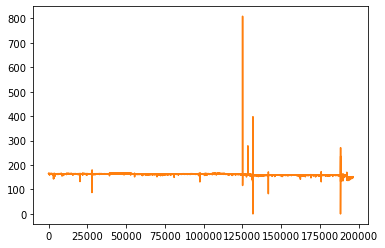

In [130]:
print(len(list(test_data)))
y_data_borpi = list(zip(*test_data))
print(len(list(test_data)))
print(len(preds))
plt.plot(list(range(len(y_data_borpi))), y_data_borpi)
plt.plot(list(range(len(preds))), preds)
plt.show()